In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy import timeseries as ts
from sunpy.time import parse_time
from sunpy.coordinates import frames, get_horizons_coord
import sunpy.map
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
import datetime
import pandas as pd
import os
from pathlib import Path
import glob
from stixdcpy.quicklook import LightCurves

import nustar_pysolar as nustar
from scipy import ndimage

import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from sunpy.coordinates import Helioprojective

import nsx_func

import warnings
warnings.simplefilter('ignore')

plt.rcParams.update({'font.size': 20,'font.family':"sans-serif",\
            'font.sans-serif':"Arial",'mathtext.default':"regular"})

In [2]:
# List of all the NuSTAR observations, with my naming, 
# based off first day of observing per campaign
dobs=['20140910','20141101','20141211',
    '20150429','20150901',
    '20160219','20160422','20160726',
    '20170321','20170821','20170911','20171010',
    '20180529','20180907','20180928',
    '20190112','20190412','20190425','20190702',
    '20200129','20200221','20200606','20200912',
    '20210108','20210429','20210720','20210730','20211117',
    '20220224','20220603','20220906','20221209',
    '20230318']

# Data directory
ddir=str(Path.home())+'/data/heasarc_nustar/'

In [3]:
# Find all pointings/IDs for the chosen observation 
# Do Feb 2002 for this initial test
icamp=32 #28 #26
maindir=ddir+'ns_'+dobs[icamp]+'/'
print(maindir)
# Most start with 20 or 90?
ids = [f.name for f in os.scandir(maindir) \
    if (f.is_dir() and (f.name.startswith('20') or f.name.startswith('90')))]
ids=sorted(ids)
for i in ids:
    print(i)


/Users/iain/data/heasarc_nustar/ns_20230318/
20801021001
20801022001
20801023001
20801024001
20801025001
20801026001
20801027001


In [12]:
nsid=ids[3]
print(nsid)

hdulist = fits.open(maindir+nsid+'/event_cl/nu'+nsid+'A06_cl_sunpos.evt')
evtdata=hdulist[1].data
hdr = hdulist[1].header
hdulist.close()

c0 = nustar.filter.event_filter(evtdata,fpm='A',energy_low=2.0, energy_high=10.0)

c00 = nustar.filter.event_filter(evtdata,fpm='A',energy_low=2.0, energy_high=10.0,dets_id=[0])
c01 = nustar.filter.event_filter(evtdata,fpm='A',energy_low=2.0, energy_high=10.0,dets_id=[1])
c02 = nustar.filter.event_filter(evtdata,fpm='A',energy_low=2.0, energy_high=10.0,dets_id=[2])
c03 = nustar.filter.event_filter(evtdata,fpm='A',energy_low=2.0, energy_high=10.0,dets_id=[3])

nn = nustar.map.make_sunpy(c0, hdr,norm_map=True,ssw_legacy=True)
nn0 = nustar.map.make_sunpy(c00, hdr,norm_map=True,ssw_legacy=True)
nn1 = nustar.map.make_sunpy(c01, hdr,norm_map=True,ssw_legacy=True)
nn2 = nustar.map.make_sunpy(c02, hdr,norm_map=True,ssw_legacy=True)
nn3 = nustar.map.make_sunpy(c03, hdr,norm_map=True,ssw_legacy=True)


20801024001


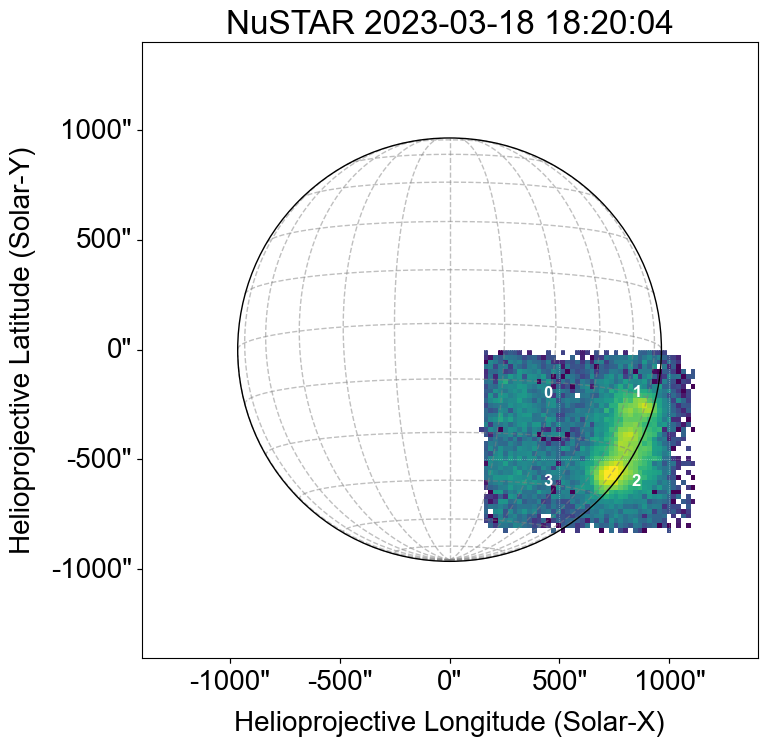

In [20]:
#  Find the mid-point of the map
# Probably have x/y row/column mixed up here

xylim=1400
bl=np.array([-1*xylim,-xylim])
tr=np.array([xylim,xylim])
bottom_left = SkyCoord(bl[0]* u.arcsec, bl[1] * u.arcsec, frame=nn.coordinate_frame)
top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame=nn.coordinate_frame)
snm = nn.submap(bottom_left, top_right=top_right)
snmr=snm.resample([128, 128] * u.pixel)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection=snmr)
snmr.plot(norm=colors.LogNorm(vmin=1e-2,vmax=1e1),cmap='viridis',axes=ax)
snmr.draw_limb(axes=ax, color="k",lw=1)
snmr.draw_grid(axes=ax, color="grey",lw=1,ls='--')
for det in range(4):
    ctemp = nustar.filter.event_filter(evtdata,fpm='A',energy_low=2.0, energy_high=10.0,dets_id=[det])
    nntemp = nustar.map.make_sunpy(ctemp, hdr,norm_map=True,ssw_legacy=True)
    bottom_left = SkyCoord(bl[0]* u.arcsec, bl[1] * u.arcsec, frame=nntemp.coordinate_frame)
    top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame=nntemp.coordinate_frame)
    snmtemp = nntemp.submap(bottom_left, top_right=top_right)
    pw,cx,cy=nsx_func.nsmapcen(snmtemp)
    ax.text((pw.Tx).to('deg').value,(pw.Ty).to('deg').value,f'{det}', \
         transform=ax.get_transform('world'),color='white',fontsize=12,fontweight='bold')
plt.show()
